# PHYS247-HW3
Steven Mills

In [1]:
import numpy as np

Use MCMC to solve the problem of homework 2 (twitter problem). Feel free to use codes below (from discussion 6) for HW3.  

Metropolis-Hastings Algorithm <br>
1. init variables (theta) <br>
2. find the posterior at initial condition (theta) <br>
3. propose new point (theta_prime), using gaussian distribution (aka random walk) <br>
4. r = posterior(theta_prime)/posterior(theta) <br>
5. generate uniform random number rand = [0, 1] <br>
6. if r > rand; move to proposal point (theta = theta_prime) <br>
7. repeat steps 2-6 for n iterations <br>

### problem 1

In [2]:
def MCMC(log_Posterior, data, initial, step_cov, n_iteration):
    np.random.seed(1113)
    param1 = np.array(initial)
    sample = np.array(initial)
    for j in range(n_iteration):
        log_Posterior_i = log_Posterior(data, param1) # theta
        #update the location
        param2 = np.random.multivariate_normal(param1, step_cov) # proposal
        #find new posterior
        log_Posterior_f = log_Posterior(data, param2)
        # generate a random number between 0 and 1
        rand = np.random.rand()
        if (log_Posterior_f - log_Posterior_i) > np.log(rand): # move
        #if np.exp(log_Posterior_f - log_Posterior_i) > rand: # move
            sample = np.vstack((sample, param2))
            param1 = param2[:]
        else:
            sample = np.vstack((sample, param1)) # don't move
    return(sample)

In [3]:
import pandas as pd

data=pd.read_csv('tweet_counts.csv')
data.head()

,week,count
0,1,39.0
1,2,46.0
2,3,41.0
3,4,42.0
4,5,31.0


In [4]:
k = data['count'].values
w = data['week'].values

In [5]:
Poisson = lambda k,λ : (λ**k)/np.math.factorial(k)*np.exp(-λ)

In [6]:
α = 1/np.mean(k)

In [7]:
def log_posterior(data, param):
    k, w = data
    lamb1, lamb2, W_s = param
    
    P=0
    
    for i in k[w<W_s]:
        P = P + np.log(Poisson(i, lamb1)*α*np.exp(-α*lamb1))

    for j in k[w >= W_s]:
        P = P + np.log(Poisson(j, lamb2)*α*np.exp(-α*lamb2))
        
    return(P)

In [8]:
D = MCMC(log_posterior, data=[k,w], initial=[20,20,20], step_cov=[[0.25,0,0],[0,0.25,0],[0,0,0.5]], n_iteration=10000)

In [9]:
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 8, 6

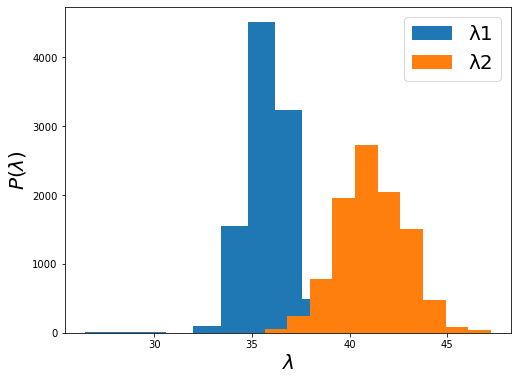

In [10]:
plt.hist(D.T[0][100:], label='λ1')
plt.hist(D.T[1][100:], label='λ2')
plt.xlabel("$\lambda$",fontsize=20)
plt.ylabel("$P(λ)$",fontsize=20)
plt.legend(fontsize=20)
plt.show()

### a)
how do the initial value of parameters and number of iterations affect the results?  
        - initial value  
            A certain "burn-in" period should be discarded to allow the Markov-chain to start to converge  
            Above, we decided to set that point at 100, by trial-and-error process (in discussion 6)   
        - number of iterations  
            In some cases, higher number of iterations might cause the parameters to vary outside the expected range
            (see picture below)   
            Maybe the MCMC algorithm can be adjusted to counter this - but it is not easy for the general case  
            Instead, some manual tuning is necessay

#### picture below - to avoid having to wait a long time to re-run it - shows what can happen if random walk runs too long and fails to converge

![title](diverge1.png)

### After spending some time to solve divergence problem, I conclude that, unfortunately, manual tuning is necessary to avoid problems

## b)
are the posteriors consistent?  Close enough, as long as tuning of initial condition and number iterations are done to avoid out-of-bounds situations

In [11]:
print('hw2 answers were: 35.71, 41.33')
P1 = D[:,0][201:]
P2 = D[:,1][201:]
print(P1.shape, P2.shape)
print('hw3 answers are: ', '%.2f,' % P1.mean(), '%.2f' % P2.mean())
print('P2-P1 mean =', '%.2f' % (P2.mean()-P1.mean()))

hw2 answers were: 35.71, 41.33
(9800,) (9800,)
hw3 answers are:  35.82, 41.20
P2-P1 mean = 5.38


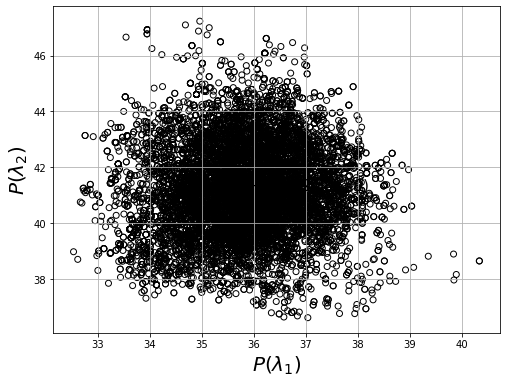

In [12]:
fig, ax = plt.subplots()
ax.scatter(P1, P2, facecolors='none', edgecolors='k')
plt.xlabel("$P(λ_1)$",fontsize=20)
plt.ylabel("$P(λ_2)$",fontsize=20)
plt.text(P1.mean(), P2.mean(), '+ (%.2f, %.2f)' % (P1.mean(), P2.mean()), fontsize=15)
plt.grid(True)
plt.show()

## c)
Find  
$P_((\lambda_2 - \lambda_1) > 5)$

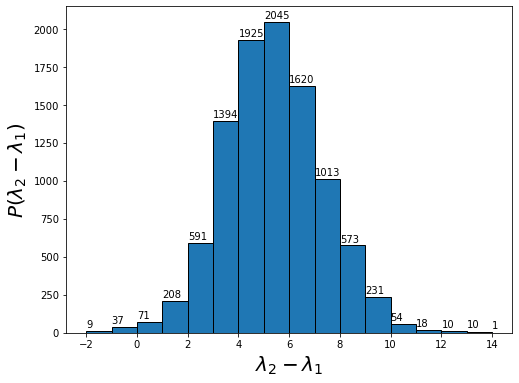

In [13]:
Pdiff = P2 - P1 
plt.rcParams["patch.force_edgecolor"] = True
bs = [-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
arr = plt.hist(Pdiff, bins=bs)
plt.xlabel("$λ_2 - λ_1$",fontsize=20)
plt.ylabel("$P(λ_2 - λ_1)$",fontsize=20)
#label bin counts
for i in bs:
    plt.text(arr[1][i], arr[0][i]+25, '%d' % (int(arr[0][i])))
plt.show()

In [14]:
print('total histogram count', len(Pdiff))
Pge5 = np.array([q for q in Pdiff if q >= 5.0])
Plt5 = np.array([q for q in Pdiff if q < 5.0])
print('count >= 5', len(Pge5), 'count < 5', len(Plt5), 'sum', len(Pge5) + len(Plt5))
print('ge count divided by total count =', '%.2f' % (len(Pge5)/len(Pdiff)))

total histogram count 9800
count >= 5 5565 count < 5 4235 sum 9800
ge count divided by total count = 0.57


So, $P[(\lambda_2-\lambda_1)>5]\sim 57\%$  
hw2 solution is 63% (?)

### problem 2

In [15]:
%reset -f

K-means Clustering based on Lloyd's algorithm  
1. start with k random centers  
2. cluster each point with the center nearest to it  
3. find the centroid of each cluster and replace the set of old centers with the centroids  
4. repeat steps 2-3 until the centers converge

### a)
write a python function that takes data points with two features (2d data) and a number of clusters and returns partitioned data.  Consider the data are located in Euclidean space.  
  
function:  kcluster(data, k) --> [[partition1], [partition2], ..., [partitionk]]  

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

### b)

In [17]:
X, Y = make_blobs(n_samples=500, cluster_std=0.8, centers=3, n_features=3, random_state=0)

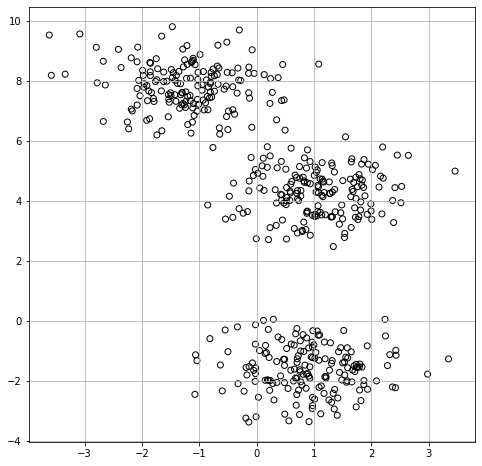

In [18]:
plt.rcParams['figure.figsize'] = 8, 8
plt.scatter(X[:,0], X[:,1], facecolors='none', edgecolors='k')
plt.grid(True)
plt.show()

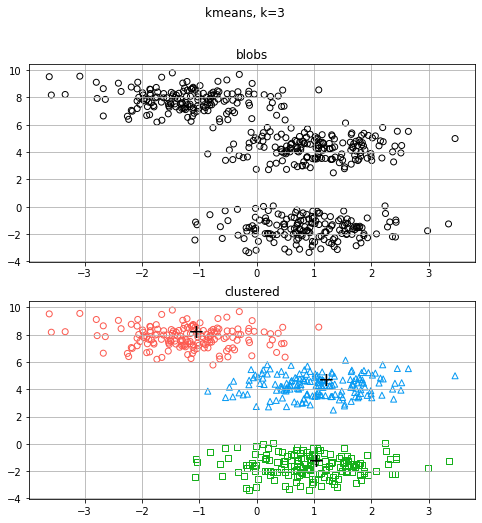

In [19]:
def d_euclid(a, b):
    return np.sqrt(np.sum(np.power(a-b, 2)))

def kmeans(data, k, fdist=d_euclid, ics=[]):
    """
        data is (n,2) array, like:  [ [a1, b1], [a2, b2], ... , [an, bn] ]
        k is the desired number of clusters
        fdist is distance calc function, euclidean distance by default

        return valid, centroids, clusters
    """
    valid_soln = True  # for example, if one of the clusters is empty, then not valid
    if len(ics) == 0:
        rand_indices = np.random.randint(data.shape[0], size=3)
        centroids = np.array([data[q] for q in rand_indices])
    else:
        centroids = ics
    cluster_assignment = [-1 for q in range(data.shape[0])]
    cluster_prev = cluster_assignment
    converge = False
    while not converge:
        for i, d in enumerate(data):
            distances = np.array([fdist(d, centroids[q]) for q in range(k)])
            cmin = distances.argmin()
            cluster_assignment[i] = cmin
        clustered = np.array(
            [np.array([data[q] for q in range(len(cluster_assignment)) if cluster_assignment[q] == j]) for j in
             range(k)])
        # compute new centroids, IF ANY CLUSTERS are empty, skip
        try:
            centroids = np.array([(clustered[q][:, 0].mean(), clustered[q][:, 1].mean()) for q in range(clustered.size)])
        except IndexError:  # this happens if a cluster is empty due to a poor initial centroid choice
            valid_soln = False
        if cluster_assignment == cluster_prev:
            converge = True
        else:
            cluster_prev = cluster_assignment
    return valid_soln, centroids, clustered

def sse(centroids, cdata):
    def distance(a, b):
        return np.sqrt(np.sum(np.power(a - b, 2)))

    def _sse(_data, _c):  # sse of 1 cluster
        return np.sum([abs(distance(d, _c)) for d in _data])

    return np.array([_sse(cdata[i], centroids[i]) for i in range(cdata.size)])

def kmeans2(kmeans, data, k, N=50):
    # call kmeans N times and choose the best clustering
    sse_min = np.inf
    icmin = None
    for i in range(N):
        rand_samples = [np.random.randint(data.shape[0]) for q in range(k)]
        ic = np.array([data[q] for q in rand_samples])
        _valid, _cs, _cd = kmeans(data, k, ics=ic)
        if _valid:
            _sse = sse(_cs, _cd).max()
            if _sse < sse_min:
                sse_min = _sse
                icmin = ic
    # return best
    return kmeans(data, k, ics=icmin)

data = np.column_stack((X[:, 0], X[:, 1]))
vld, centroids, cdata = kmeans2(kmeans, data, 3)

# plot the output
markers = ['o', 's', '^']
colors = ['xkcd:coral', 'xkcd:green', 'xkcd:azure']

plt.rcParams['figure.figsize'] = 8, 8
fig, axs = plt.subplots(2)
fig.suptitle('kmeans, k=3')
axs[0].scatter(X[:,0], X[:,1], facecolors='none', edgecolors='k')
axs[0].set_title('blobs')
axs[0].grid()

for i, c in enumerate(cdata):
    axs[1].scatter(c[:,0], c[:,1], marker=markers[i], facecolors='none', edgecolors=colors[i])
    axs[1].text(centroids[i][0], centroids[i][1], '+', fontsize=20, color='k')
axs[1].set_title('clustered')
axs[1].grid()

### c)  
how do I know k should be 3?  
we can try different k clusters and check SSE for each  
apparently, this is called the ELBOW METHOD 

### d)
apply ELBOW method at k=3 example  
k > 3 doesn't significantly improve SSE metric (aka "intertia")   

[500.95438418 161.81403923 113.30330607  88.56527907  66.29049796
  52.86364625  45.52025039  38.79117033  34.35177798  29.35403235
  25.52187541]


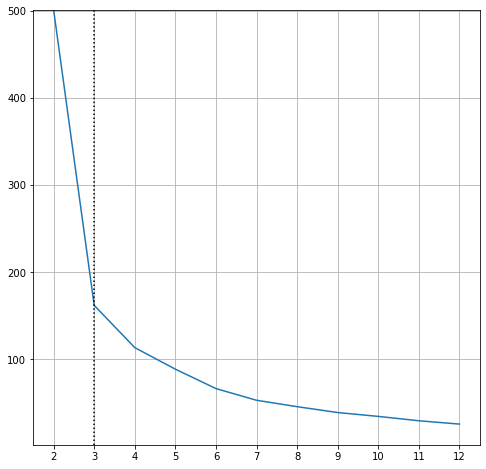

In [20]:
data = np.column_stack((X[:, 0], X[:, 1]))
sses = np.array([])
kmax = 12
for k in range(2, kmax+1):
    vld, centroids, cdata = kmeans2(kmeans, data, k)
    sses = np.append(sses, sse(centroids, cdata).mean())
print(sses)
plt.plot(np.arange(2, kmax+1), sses)
plt.xticks(np.arange(2,kmax+1))
plt.ylim(top=sses.max())
plt.grid(True)
plt.axvline(x=3, c='k', linestyle=':')
plt.show()

apply ELBOW METHOD, k=6
k > 6 doesn't significantly improve SSE intertia  

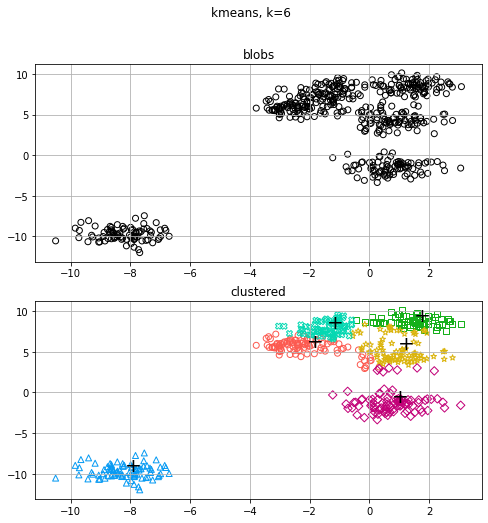

In [21]:
known = 6
X4, Y4 = make_blobs(n_samples=500, cluster_std=0.8, centers=known, n_features=3, random_state=0)
vld, centroids, cdata = kmeans2(kmeans, np.column_stack((X4[:, 0], X4[:, 1])), known)

# plot the output
markers = ['o', 's', '^', '*', 'X', 'D']
colors = ['xkcd:coral', 'xkcd:green', 'xkcd:azure', 'xkcd:gold', 'xkcd:aquamarine', 'xkcd:magenta']

plt.rcParams['figure.figsize'] = 8, 8
fig, axs = plt.subplots(2)
fig.suptitle('kmeans, k=%d' % known)
axs[0].scatter(X4[:,0], X4[:,1], facecolors='none', edgecolors='k')
axs[0].set_title('blobs')
axs[0].grid()

for i, c in enumerate(cdata):
    axs[1].scatter(c[:,0], c[:,1], marker=markers[i], facecolors='none', edgecolors=colors[i])
    axs[1].text(centroids[i][0], centroids[i][1], '+', fontsize=20, color='k')
axs[1].set_title('clustered')
axs[1].grid()

[903.79226347 362.73783933 193.03756296 126.49363428  91.04451046
  70.30497132  55.0044478   48.2332655   42.3927508   35.89075016
  34.00400781]


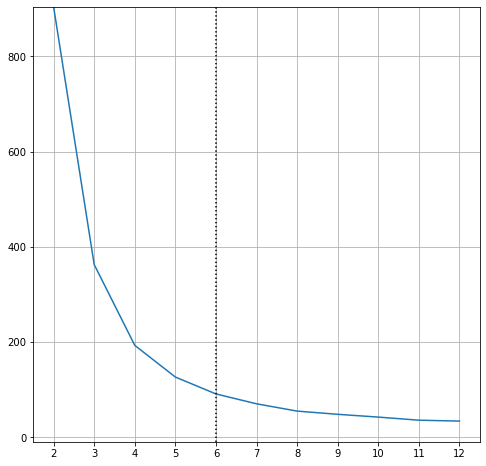

In [22]:
sses = np.array([])
kmax = 12
for k in range(2, kmax+1):
    vld, centroids, cdata = kmeans2(kmeans, np.column_stack((X4[:, 0], X4[:, 1])), k)
    sses = np.append(sses, sse(centroids, cdata).mean())
print(sses)
plt.plot(np.arange(2, kmax+1), sses)
plt.xticks(np.arange(2,kmax+1))
plt.ylim(top=sses.max())
plt.grid(True)
plt.axvline(x=known, c='k', linestyle=':')
plt.show()

#### try a random number of blobs and guess at what it might be

[906.63682968 354.54908785 194.79483655 116.42157974  82.63398011
  66.2565822   56.25290968  50.00318268  42.32092592  36.95522266
  32.29498281]


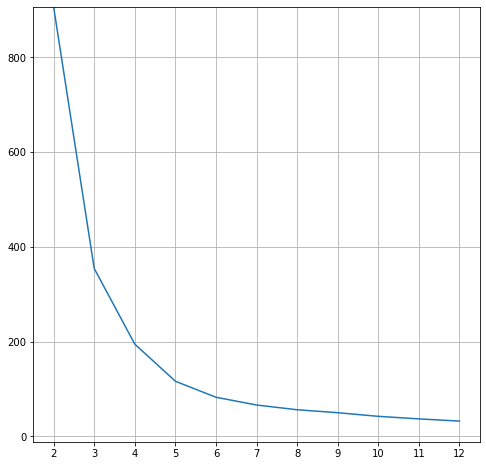

In [27]:
np.random.seed(1113)
known = np.random.randint(12)

XN, YN = make_blobs(n_samples=500, cluster_std=0.8, centers=known, n_features=3, random_state=0)
vld, centroids, cdata = kmeans2(kmeans, np.column_stack((XN[:, 0], XN[:, 1])), known)

sses = np.array([])
kmax = 12
for k in range(2, kmax+1):
    vld, centroids, cdata = kmeans2(kmeans, np.column_stack((X4[:, 0], X4[:, 1])), k)
    sses = np.append(sses, sse(centroids, cdata).mean())
print(sses)
plt.plot(np.arange(2, kmax+1), sses)
plt.xticks(np.arange(2,kmax+1))
plt.ylim(top=sses.max())
plt.grid(True)
plt.show()

#### based on the picture, I guess between 5 and 7

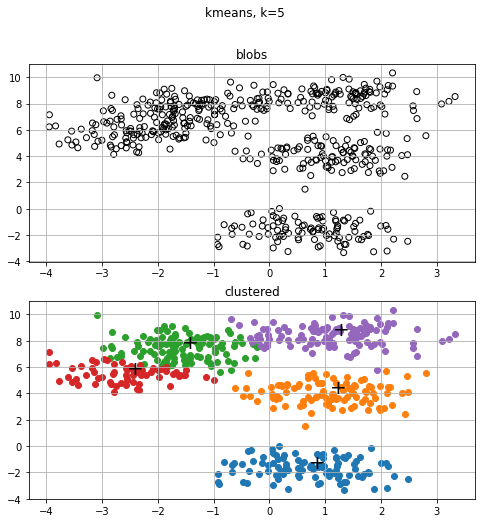

In [28]:
vld, centroids, cdata = kmeans2(kmeans, np.column_stack((XN[:, 0], XN[:, 1])), known)
# plot the output
#markers = ['o', 's', '^', '*', 'X', 'D', 'v']
#colors = ['xkcd:coral', 'xkcd:green', 'xkcd:azure', 'xkcd:gold', 'xkcd:aquamarine', 'xkcd:magenta']

plt.rcParams['figure.figsize'] = 8, 8
fig, axs = plt.subplots(2)
fig.suptitle('kmeans, k=%d' % known)
axs[0].scatter(XN[:,0], XN[:,1], facecolors='none', edgecolors='k')
axs[0].set_title('blobs')
axs[0].grid()

for i, c in enumerate(cdata):
    #axs[1].scatter(c[:,0], c[:,1], marker=markers[i], facecolors='none', edgecolors=colors[i])
    axs[1].scatter(c[:,0], c[:,1])
    axs[1].text(centroids[i][0], centroids[i][1], '+', fontsize=20, color='k')
axs[1].set_title('clustered')
axs[1].grid()

### Conclusion:  Elbow method can be hard to find the "real" elbow, therefore we need to investigate other methods such as Silhouette, x-means clustering, etc.   
https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set